<a href="https://colab.research.google.com/github/yaobviously/DataCup2021/blob/main/hockeypassingmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [147]:
!pip install category_encoders --quiet
!pip install shap --quiet
!pip install pdpbox --quiet

In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import shap
import math
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, plot_roc_curve, plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
plt.style.use('default')


URL = 'https://raw.githubusercontent.com/yaobviously/DataCup2021/main/modifiedohl.csv'

In [149]:
def wrangle(URL):
  df = pd.read_csv(URL,
                   parse_dates = ['game_date'],
                   index_col = 'game_date')
  
  # dropping columns i made awhile ago that i don't need to build models, 
  # although they may be handy for communicating insights. all of the score
  # and player differentials can now, i see, be reduced to single columns for
  # the purposes of model building

  col_drop = ['Unnamed: 0', 'possSet', 'shots_next_ten', 'goal_next_ten', 
              '5on5', '5on4home', '5on3home', '5on4away', '5on3away', 
              '4on4', 'tie', 'home_ahead_1', 'home_ahead_2', 'home_ahead_3ormore',
              'away_ahead_1', 'away_ahead_2', 'away_ahead_3ormore', 'home_team',
              'away_team', 'is_shot', 'detail_2']

  df = df.drop(columns = col_drop).copy()
  df = df.rename(columns = {'detail_3' : 'traffic', 'detail_4' : 'one_timer',
                            'detail_1' : 'pass_type'})
  
  # condensing the above columns

  df['home_skater_adv'] = df['home_team_skaters'] - df['away_team_skaters']
  df['home_score_diff'] = df['home_team_goals'] - df['away_team_goals']
  df['is_shot'] = [1 if event in ['Goal', 'Shot'] else 0 for event in df['event']]

  # converting the clock column to the seconds remaining in the period in the
  # ugliest way imaginable
  
  df['min'] = df.clock.apply(lambda x: datetime.datetime.strptime(x,'%M:%S')).dt.minute
  df['sec'] = df.clock.apply(lambda x: datetime.datetime.strptime(x, '%M:%S')).dt.second
  df['period_sec_rem'] = df['min'] * 60 + df['sec']
  
  df.drop(columns = 'clock', inplace = True)

  # calculating the seconds remaining in the game, mostly for practice (needed!)

  def gamesecs(x):
  
    if x['period'] == 1:
      return x['period_sec_rem'] + 2400

    if x['period'] == 2:
      return x['period_sec_rem'] + 1200
  
    else:
      return x['period_sec_rem']

  df['game_sec_rem'] = df.apply(gamesecs, axis = 1)

  # creating new columns that contain info on prior game states

  df['x_coordinate_1back'] = df['x_coordinate'].shift()
  df['y_coordinate_1back'] = df['y_coordinate'].shift()
  df['x_coordinate_2back'] = df['x_coordinate'].shift(2)
  df['y_coordinate_2back'] = df['y_coordinate'].shift(2)
  df['event_1back'] = df['event'].shift()
  df['event_2back'] = df['event'].shift(2)

  df['sec_last_event'] = np.abs(df.groupby(['gameid', 'period'])['period_sec_rem'].diff())
  df['sec_2ndlast_event'] = np.abs(df.groupby(['gameid', 'period'])['period_sec_rem'].diff(2))

  # dropping redundant and leaky columns. note 'event' may be useful for
  # finding and creating useful (and non-leaky) features
  
  df.drop(columns = ['min', 'sec'], inplace = True)

  # dropping columns with negligible importance. note 'team' & 'period may be 
  # useful for finding and creating useful (and non-leaky) features.

  lowimp_columns = ['away_team_goals', 'home_team_goals', 
                    'home_team_skaters','away_team_skaters', 'traffic', 'event_2back',
                    'game_sec_rem', 'period', 'gameid', 'one_timer',
                    'is_shot',  'is_goal', 'period_sec_rem',
                    'sec_last_event', 'x_coordinate_1back', 'y_coordinate_1back',
                    'event_1back', 'x_coordinate_2back', 'y_coordinate_2back',
                    'sec_2ndlast_event', 'home_score_diff']

  

  df.drop(lowimp_columns, axis = 1, inplace = True)
  
  # Filtering the DataFrame to include only rows in which a pass was recorded

  df = df[df['event'].isin(['Play', 'Incomplete Play'])]
  df['event'] = df['event'].map({'Play' : 1, 'Incomplete Play' : 0})

  # adding a feature or two

  df['forward_pass'] = (df['x_coordinate_2'] > df['x_coordinate']).astype(int)
  df['x_dist'] = df['x_coordinate_2'] - df['x_coordinate']
  df['y_dist'] = df['y_coordinate_2'] - df['y_coordinate']
  df['pass_distance'] = np.sqrt(df['x_dist'] ** 2 + df['y_dist'] ** 2)
  df['pass_angle'] = [math.asin(x) for x in (df['y_dist'] / df['pass_distance'])]

  df.drop(columns = ['x_dist', 'y_dist', 'pass_distance'], inplace = True)
  df = df.rename(columns = {'event' : 'pass_success'})

  return df

In [150]:
# below i create a smaller dataframe with information that will be stitched back
# onto the main df to assess and compare player skill

df = wrangle(URL)

player_eval = df[['player', 'player_2', 'team']].copy()

df.drop(columns = player_eval.columns, inplace = True)

In [151]:
# this is the baseline frequency of pass succes

baseline_frequency = df.pass_success.value_counts(normalize = True).max()
print('Using the base rate as the predictor would yield an accuracy of:', baseline_frequency)

Using the base rate as the predictor would yield an accuracy of: 0.727868250275499


In [152]:
# identifying the target and dividing the data into train, eval, and test sets. 


target = 'pass_success'

train_threshold = '2020-01-20'
test_threshold = '2020-02-13'

mask = df.index < train_threshold
mask2 = df.index > test_threshold

X = df.drop(target, axis = 1)
y = df[target]

X_train, y_train = X[mask], y[mask]
X_val, y_val = X[~mask & ~mask2], y[~mask & ~mask2]
X_test, y_test = X[~mask], y[~mask]

In [153]:
# specifying the model. the hyperparameters were chosen using gridsearch on the
# validation set

model_xg = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(objective = 'binary:logistic',
                  eval_method = 'auc',
                  max_depth = 3,
                  n_estimators = 500)
)
    
model_xg.fit(X_train, y_train);

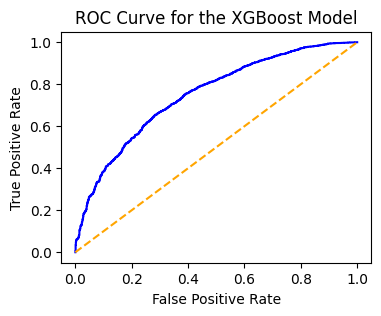

In [220]:
# plotting the ROC curve for the XGBoost passing model

fp, tp, thr = roc_curve(y_val, model_xg.predict_proba(X_val)[:,1])

plt.plot(fp, tp, c = 'blue')
plt.plot([0,1], ls = '--', c = 'orange')
plt.title('ROC Curve for the XGBoost Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.gcf().set_size_inches(4,3)
plt.show();

In [155]:
print('The AUC score for the XGBoost model is:', roc_auc_score(y_val, model_xg.predict_proba(X_val)[:,1]))

The AUC score for the XGBoost model is: 0.7493340750630472


In [ ]:
# creating a feature importances series from the parameters of the model object

features = model_xg.named_steps['ordinalencoder'].get_feature_names()
importances = model_xg.named_steps['xgbclassifier'].feature_importances_

pd.Series(importances, index = features)

In [ ]:
# creating a feature importances dataframe using the permutation importance 
# function.

perm_imp = permutation_importance(model_xg, X_test, y_test, n_repeats = 5)

perm_dict = {
    'means' : perm_imp['importances_mean'],
    'std' : perm_imp['importances_std']
}

pd.DataFrame(perm_dict, index = features)

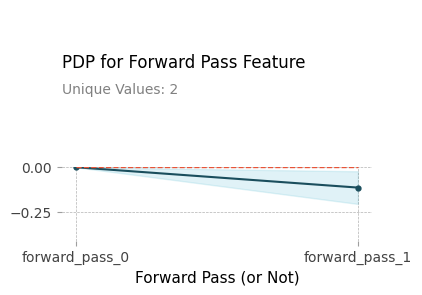

In [236]:
# creating a pdp plot for whether or not it was a 'forward pass'. unsurprisingly,
# forward passes were *less* likely to be completed. 

isolate = pdp_isolate(model_xg,
                      X_val.fillna(method = 'bfill'), 
                      X_val.columns,
                      feature = 'forward_pass',
                      )

plot = pdp_plot(isolate,
                feature_name = 'Forward Pass (or Not)',                
                figsize = (4,3),
                plot_params = {'title' : 'PDP for Forward Pass Feature',
                               'subtitle' : 'Unique Values: 2',
                               'title_fontsize' : 12,
                               'subtitle_fontsize' : 10})


plt.show();

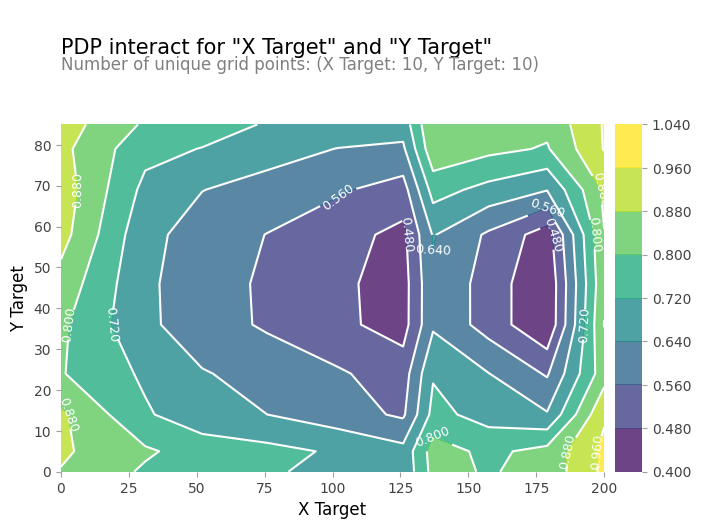

In [200]:
# creating a PDP plot for the interaction between the x and y coordinates of the 
# pass receiver location. we can see from the plot that passes towards the middle
# of the ice towards the offensive zone and, of course, the net are much less
# likely to be completed

interact = pdp_interact(model_xg,
                        X_val,
                        X_val.columns,
                        features = ['x_coordinate_2', 'y_coordinate_2'])

interact_plot = pdp_interact_plot(interact,
                                  feature_names = ['X Target', 'Y Target'],
                                  plot_type = 'contour')

interact_plot

plt.gcf().set_size_inches(plt.gcf().get_size_inches()[0],6)
plt.savefig('interactplot.png')
plt.show();

In [191]:
# Replicating my model to make it legible to SHAP

encoder = OrdinalEncoder()
imputer = SimpleImputer()

Xval_encoded = encoder.fit_transform(X_val)
Xval_imputed = imputer.fit_transform(Xval_encoded)
Xval_df = pd.DataFrame(Xval_imputed, columns = X_val.columns)


booster = XGBClassifier(objective = 'binary:logistic',
                        eval_method = 'auc',
                        max_depth = 3,
                        n_estimators = 500)

booster.fit(Xval_imputed, y_val);

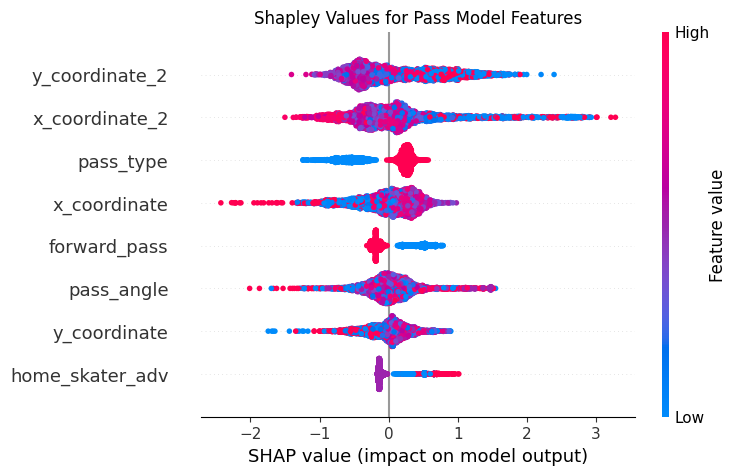

In [215]:
shap_explainer = shap.TreeExplainer(booster)
shap_values = shap_explainer.shap_values(Xval_imputed)

shap.summary_plot(shap_values,
                  Xval_df,
                  show = False)

plt.title('Shapley Values for Pass Model Features')
plt.gcf().set_size_inches(7,5)
plt.savefig('shapvalspass.png')
plt.show();


In [166]:
# stitching the player data back onto the dataframe to enable player comparisons
# using the model's output. 

features = X_test.columns

player_df = pd.concat([df, player_eval], axis =1)
player_df['predicted_pass_prob'] = model_xg.predict_proba(df[features])[:,1]
otters = player_df[player_df['team'] == 'Erie Otters']

In [167]:
# creating a dataframe of Erie Otters players when they're the passer

otters_passers = otters.groupby('player').agg(avg_model_pass_prob = ('predicted_pass_prob', 'mean'),
                                              pass_success_rate = ('pass_success', 'mean'),
                                              total_passes = ('player', 'count'))


In [ ]:
# expanding the otters players passing df by calculating their "passes above exp"

otters_passers['expected_successes'] = otters_passers['avg_model_pass_prob'] * otters_passers['total_passes']
otters_passers['actual_successes'] = otters_passers['pass_success_rate'] * otters_passers['total_passes']
otters_passers['successes_above_expectation'] = (otters_passers['actual_successes'] - otters_passers['expected_successes']).round(1)
otters_passers['PAEper100'] = otters_passers['successes_above_expectation'] / (otters_passers['total_passes']/100)

otters_passers[otters_passers['total_passes'] >= 200][['total_passes', 'avg_model_pass_prob', 'successes_above_expectation', 'PAEper100']]


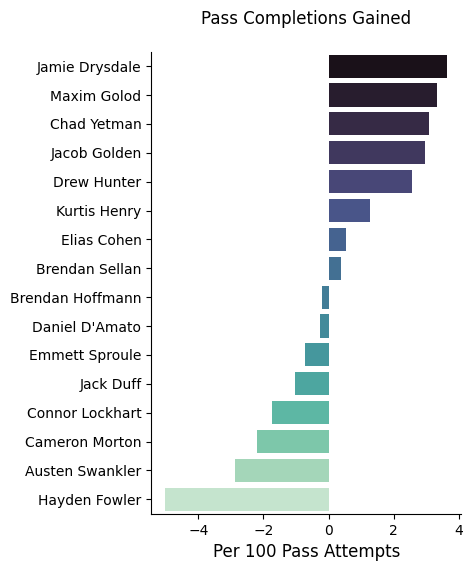

In [195]:
# Plotting pass completions gained per 100 pass attempts. Note that Jamie Drysdale
# and Maxim Golod are considered the two top prospects on the Erie Otters, so
# this result accords with the consensus among scouting professionals. 

otters_passers_filtered = (otters_passers[otters_passers['total_passes'] >= 400]
                           .reset_index()
                           .sort_values(by = 'PAEper100', ascending = False)                           
)


ax = sns.barplot('PAEper100',
                 'player',
                 data = otters_passers_filtered,
                 palette = 'mako',
                 orient = 'h')

plt.gcf().set_size_inches(plt.gcf().get_size_inches()[0],6)

ax.set_title('Pass Completions Gained',
             pad = 20,
             fontsize = 12)
ax.set_ylabel('')
ax.set_xlabel('Per 100 Pass Attempts',
              fontsize = 12)
sns.despine()
plt.show();

In [ ]:
# creating a DataFrame of Erie Otter players when they're the pass target

otters_targets = otters.groupby('player_2').agg(avg_model_rec_prob = ('predicted_pass_prob', 'mean'),
                                                 receive_succ_rate = ('pass_success', 'mean'),
                                                 total_targets = ('player_2', 'count')
                                                 )

In [ ]:
# expanding the otters players target df by  calculating their 
# "passes received over expectation" and passes_received_over_expectation/100

otters_targets['expected_successes'] = otters_targets['avg_model_rec_prob'] * otters_targets['total_targets']
otters_targets['actual_successes'] = otters_targets['receive_succ_rate'] * otters_targets['total_targets']
otters_targets['passes_rec_above_expectation'] = (otters_targets['actual_successes'] - otters_targets['expected_successes']).round(1)

otters_targets['SAEper100'] = (otters_targets['passes_rec_above_expectation'] / (otters_targets['total_targets'] / 100)).round(2)

otters_targets[otters_targets['total_targets'] >= 200][['total_targets', 'avg_model_rec_prob', 'passes_rec_above_expectation','SAEper100']]

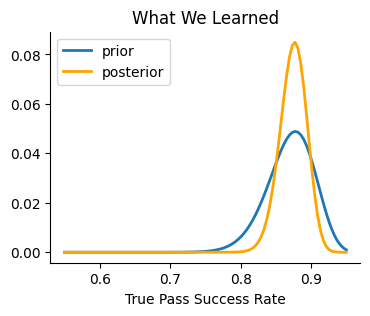

In [212]:
# using simple grid approximation to update a prior on the passing skill of
# Aidan campbell of the Erie Otters. good practice!
import scipy
from scipy.stats import beta
from scipy.stats import binom

# specifying the range of possible values for Aidan Campbell's true passing 
# success rate

possible_rates = [n for n in np.linspace(0.55, 0.95, 100)]

# computing prior probabilities for pass success probability using the beta distribution.
# the prior comes from the model's estimate of pass success given the passes 
# plus my domain expertise with respect to the uncertainty. subjective. note
# that he attempted very low-risk passes. 

prior_over_rates = beta.pdf(possible_rates, a = 87, b = 13)
prior_normed = prior_over_rates/prior_over_rates.sum()

# computing the likelihood of the observations -- 177 successful passes out of 
# 202 total passes (see otters_passers dataframe, Aidan Campbell)

successes = otters_passers.loc['Aidan Campbell']['actual_successes']
attempts = otters_passers.loc['Aidan Campbell']['total_passes']

likelihoods = binom.pmf(successes, attempts, possible_rates)
likelihoods_normed = likelihoods/likelihoods.sum()

# computing the posterior by multiplying the likelihoods by the prior

posterior_unnormed = likelihoods * prior_over_rates
posterior_normed = posterior_unnormed/posterior_unnormed.sum()

# plotting the prior and the posterior. the plot shows that we are much more
# confident that Aidan Campbell has average passing skill after adjusting for the
# difficulty of his passes. note that he chooses very safe passes, which itself
# indicates something interesting about his skillset/potential, but that's another
# topic. 


plt.plot(possible_rates, prior_normed, lw=2, label = 'prior')
plt.plot(possible_rates, posterior_normed, lw = 2, c = 'orange', label = 'posterior')
plt.title("What We Learned")
plt.xlabel('True Pass Success Rate')
plt.ylabel('')
plt.legend(loc = 'best')
plt.gcf().set_size_inches(4,3)
sns.despine()
plt.show();
